In [91]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
import time

In [92]:
pd.set_option('display.max_columns', 200)
df = pd.read_csv('preprocessed.csv')
df.head()

,Unnamed: 0,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,0,5,1,1,41,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
1,1,15,3,9,59,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
2,2,25,2,6,11,5,13,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0

Since preprocessed file included all original columns plus the one-hot features, we can only select the columns that we need for training our model:

In [93]:
df = df.drop(df.columns[0],axis=1)
print(df.shape)
df.head()

(99340, 166)


,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,5,1,1,41,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
1,15,3,9,59,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
2,25,2,6,11,5,13,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,

In [94]:
# input features
# X = df.iloc[:,:-3]
# # labels
# y = df.iloc[:,-3:]

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(df_train.shape,df_test.shape)
print(df_train.shape,df_test.shape)

(79472, 166) (19868, 166)
(79472, 166) (19868, 166)


In [95]:
def calculate_prevalence(y):
    print(sum(y)/len(y))

calculate_prevalence(df.iloc[:,-3])
calculate_prevalence(df_train.iloc[:,-3])
calculate_prevalence(df_test.iloc[:,-3])

0.1138916851218039
0.11421632776323737
0.11259311455607006


## Undersampling or Oversampling?

In [96]:
# def balance_out_trainset(X_train, y_train, method):
    
    

#     df_train = pd.concat([X_train, y_train],axis=1)
#     newdf = df
    
#     if method == 'undersample':
#         class_lt30 = df_train[df_train['readmitted_<30'] == 1]
#         class_notlt30 = df_train[df_train['readmitted_<30'] == 0]
#         class_gt30 = df_train[df_train['readmitted_>30'] == 1]
#         class_no = df_train[df_train['readmitted_NO'] == 1]
#         new_df = pd.concat([class_lt30, class_notlt30.sample(n=len(class_lt30),random_state=42)],axis=0)
#         new_df = new_df.sample(frac=1,random_state=42).reset_index(drop=True)
#         X = df_train.iloc[:,:-3]
 
#     elif method == 'oversample':
#         oversample = SMOTE()
#         X, y = oversample.fit_resample(X_train, y_train)


In [97]:
df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
17017,65,6,4,52,6,33,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1
13879,65,7,9,38,3,25,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
12255,15,3,2,14,0,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1

In [98]:
#Undersampling
class_lt30 = df_train[df_train['readmitted_<30'] == 1]
class_notlt30 = df_train[df_train['readmitted_<30'] == 0]

# balanced_df_train = pd.concat([class_lt30, class_notlt30.sample(n=len(class_lt30),random_state=42)],axis=0)
balanced_df_train = df_train.copy()
balanced_df_train = balanced_df_train.sample(frac=1,random_state=42).reset_index(drop=True)
balanced_df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,85,3,5,28,2,16,3,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,85,7,9,56,0,18,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
2,85,5,9,45,0,12,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,

In [99]:
# calculate_prevalence(balanced_df_train.iloc[:,-3:-2],'trainig set')

Let's seperate the dataframe into labels(y) and features (X): 

In [100]:
all_X_train = df_train.iloc[:,:-3]
X_train = balanced_df_train.iloc[:,:-3].values
X_test = df_test.iloc[:,:-3].values

y_train = balanced_df_train.iloc[:,-3].values
y_test = df_test.iloc[:,-3].values

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
calculate_prevalence(y_train)

(79472, 163) (79472,) (19868, 163) (19868,)
0.11421632776323737


In [101]:
# # !pip install imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE, KMeansSMOTE, ADASYN,RandomOverSampler, SVMSMOTE
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler
# oversample = SMOTE()
# oversample = SVMSMOTE(random_state=42)
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [102]:
# counter = Counter(y_train)
# print(X_train.shape)
# print(counter)
# calculate_prevalence(y_train)

To make sure that different size in the variables is not going to make a problem in any of the models, we should normalize them. One way to do that is to use the standard scaler which removes the mean and scales down to unit variance.

In [103]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

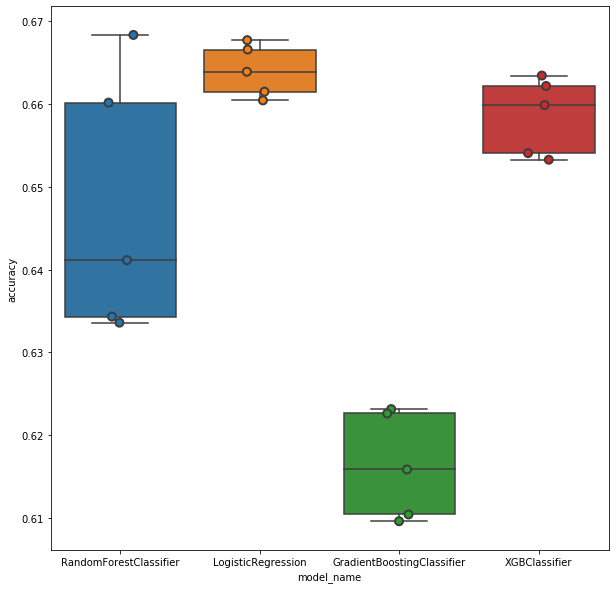

In [104]:
# !pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42),
    XGBClassifier(random_state=42,learning_rate=0.01)
    
]
kf = 5
cv_df = pd.DataFrame(index=range(kf * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42),shuffle(random_state=42), model)
    accuracies = cross_val_score(imba_pipeline, X_train_tf, y_train, scoring='accuracy', cv=kf)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,ax=ax, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [105]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GradientBoostingClassifier    0.616330
LogisticRegression            0.664045
RandomForestClassifier        0.647524
XGBClassifier                 0.658584
Name: accuracy, dtype: float64

In [106]:
def print_results(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    labels = ['Not readmiited <30 days', 'readmiited <30 days']
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(metrics.classification_report(y_test, y_pred))

In [107]:
def plot_important_features(model, column_names, num_features, plot_title, first_or_last = 'first'):
    
    if model.__class__.__name__ == 'LogisticRegression':
        feature_importances = model.coef_[0]
    else:
        feature_importances = model.feature_importances_

    feature_importances = pd.DataFrame(feature_importances,
                                       index = column_names,
                                        columns=['importance']).sort_values('importance',
                                                                            ascending=False)
    ylocs = np.arange(num_features)
    if first_or_last == 'last':
        values_to_plot = feature_importances.iloc[-num_features:].values.ravel()
        feature_labels = list(feature_importances.iloc[-num_features:].index)

    else:
        # get the feature importance for top num and sort in reverse order
        values_to_plot = feature_importances.iloc[:num_features].values.ravel()[::-1]
        feature_labels = list(feature_importances.iloc[:num_features].index)[::-1] 

    plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
    plt.barh(ylocs, values_to_plot, align = 'center')
    plt.ylabel('Features')
    plt.xlabel('Importance Score')
    plt.title(plot_title)
    plt.yticks(ylocs, feature_labels)
    plt.show()

In [108]:
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,7,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

params = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}
new_params = {'xgbclassifier__' + key: params[key] for key in params}

auc = make_scorer(roc_auc_score)
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42),shuffle(random_state=42), models[3])
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=2, scoring=auc,
                        return_train_score=True)
# grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params,n_iter = 20, cv=2, scoring=auc,
#                         return_train_score=True)

In [109]:
grid_imba.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'nonetype', 'xgbclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__nthread', 'xgbclassifier__objective', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__seed', 'xgbclassifier__silent', 'xgbclassifier__subsample', 'xgbclassifier__verbosity'])

In [110]:
grid_imba.fit(X_train_tf, y_train)
grid_imba.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 2,
 'xgbclassifier__n_estimators': 400}

In [111]:
grid_imba.best_score_

0.6193737673814386

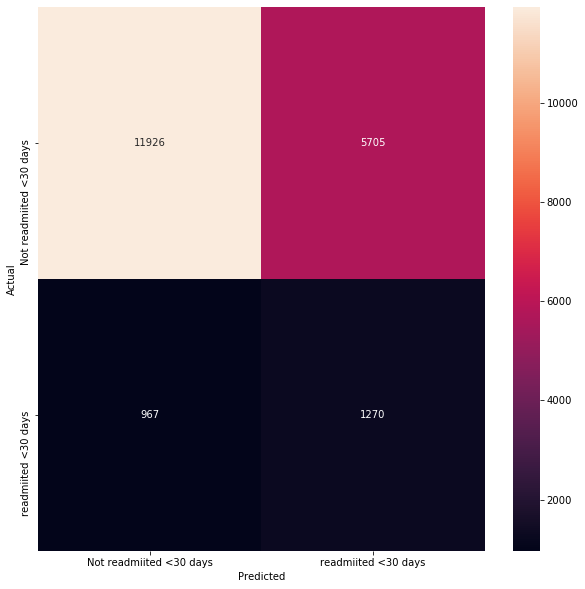

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17631
           1       0.18      0.57      0.28      2237

    accuracy                           0.66     19868
   macro avg       0.55      0.62      0.53     19868
weighted avg       0.84      0.66      0.72     19868



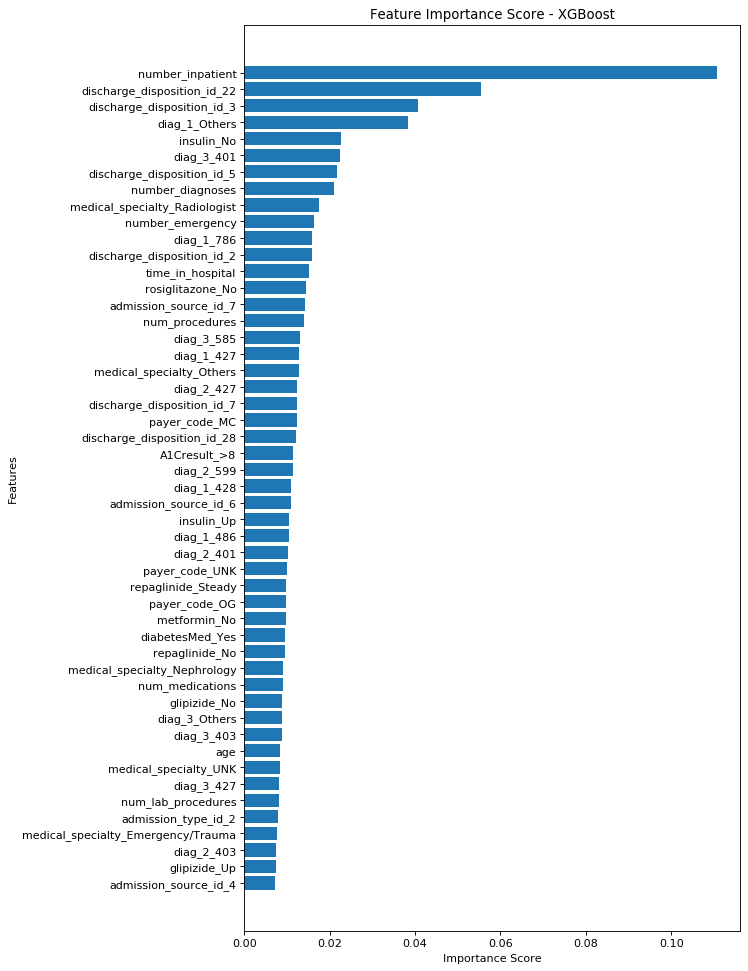

In [112]:
best_xgb_model = grid_imba.best_estimator_.named_steps['xgbclassifier']
y_test_predict = best_xgb_model.predict(X_test_tf)
print_results(y_test, y_test_predict)
plot_important_features(best_xgb_model, list(all_X_train.columns), 50, 'Feature Importance Score - XGBoost')

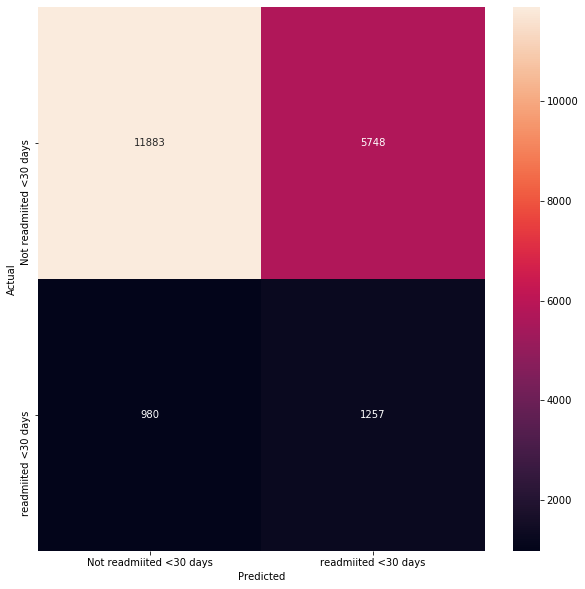

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     17631
           1       0.18      0.56      0.27      2237

    accuracy                           0.66     19868
   macro avg       0.55      0.62      0.53     19868
weighted avg       0.84      0.66      0.72     19868



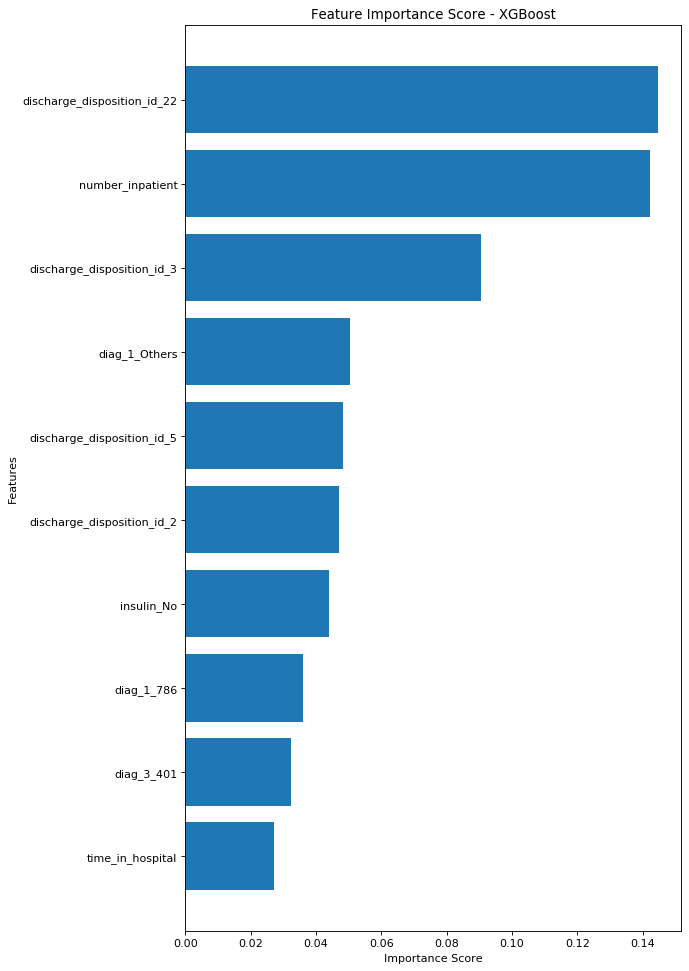

In [118]:
selection = SelectFromModel(best_xgb_model, threshold=0.01, prefit=True)
undersample = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersample.fit_resample(X_train_tf, y_train)
X_train_us, y_train_us = shuffle(X_train_us, y_train_us, random_state=42)
select_X_train = selection.transform(X_train_us)

selection_model = XGBClassifier(learning_rate=0.1, max_depth=2,n_estimators=400)
selection_model.fit(select_X_train, y_train_us)  

select_X_test = selection.transform(X_test_tf)
y_pred = selection_model.predict(select_X_test)
print_results(y_test, y_pred)
plot_important_features(selection_model, list(all_X_train.columns[selection.get_support()]), 10, 'Feature Importance Score - XGBoost')

## Logistic regression model Results and Important Features

In [113]:
penalty = ['l1', 'l2']
lrparams = {'penalty':penalty}
new_lrparams = {'logisticregression__' + key: lrparams[key] for key in lrparams}

auc = make_scorer(roc_auc_score)
lr_imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42),shuffle(random_state=42), models[1])
lr_grid_imba = GridSearchCV(lr_imba_pipeline, param_grid=new_lrparams, cv=2, scoring=auc,
                        return_train_score=True)
lr_grid_imba.fit(X_train_tf, y_train)
lr_grid_imba.best_params_

{'logisticregression__penalty': 'l2'}

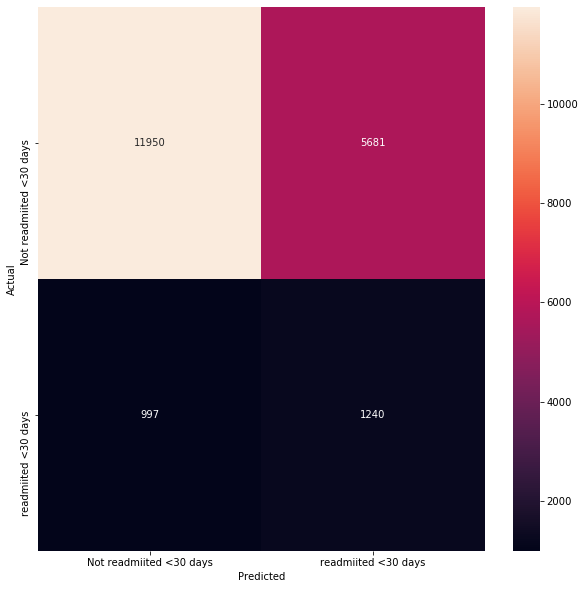

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17631
           1       0.18      0.55      0.27      2237

    accuracy                           0.66     19868
   macro avg       0.55      0.62      0.53     19868
weighted avg       0.84      0.66      0.72     19868



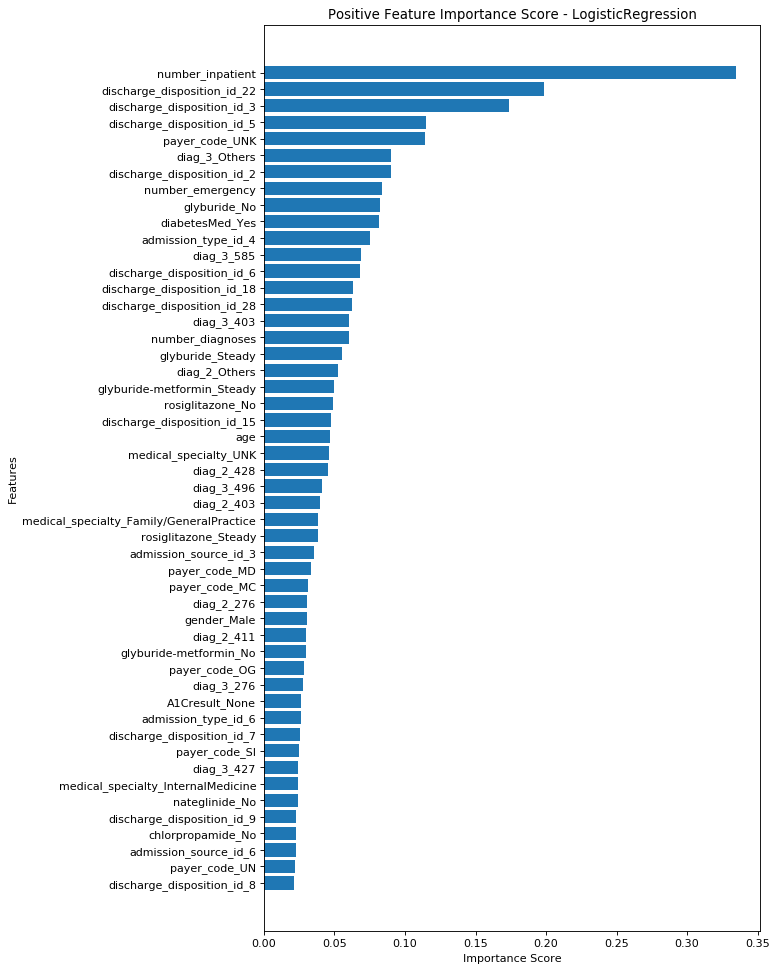

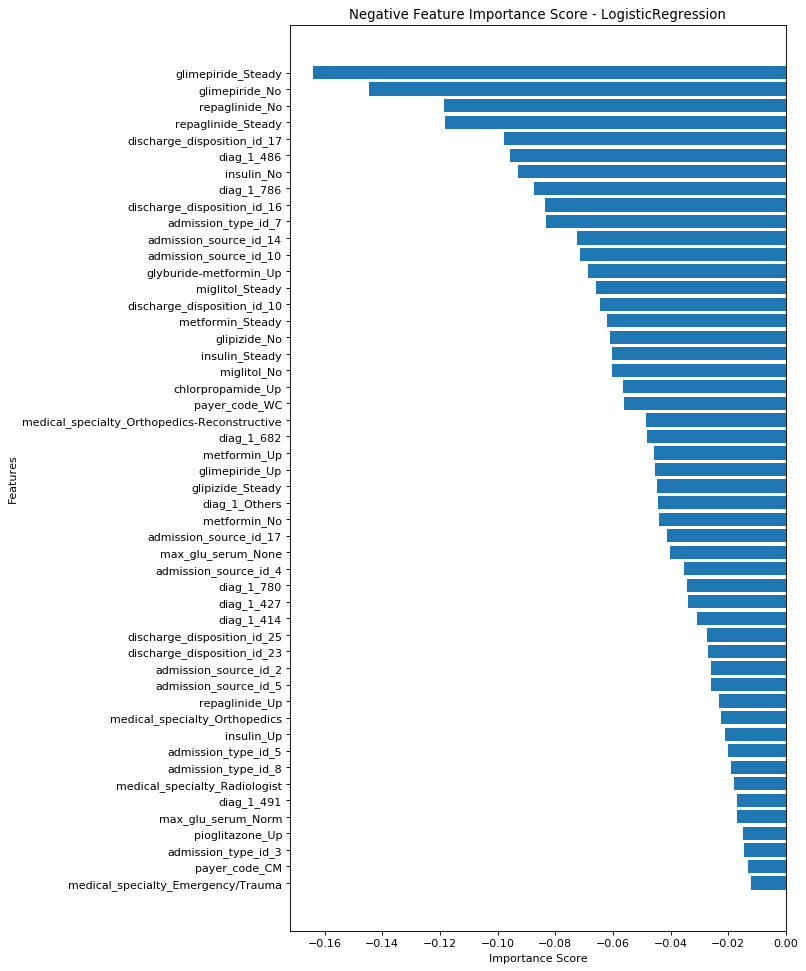

In [114]:
best_lr_model = lr_grid_imba.best_estimator_.named_steps['logisticregression']
y_test_predict = best_lr_model.predict(X_test_tf)
print_results(y_test, y_test_predict)
plot_important_features(best_lr_model, list(all_X_train.columns), 50, 'Positive Feature Importance Score - LogisticRegression')
plot_important_features(best_lr_model, list(all_X_train.columns), 50, 'Negative Feature Importance Score - LogisticRegression','last')

In [115]:
print(X_train_tf.shape)

(79472, 163)


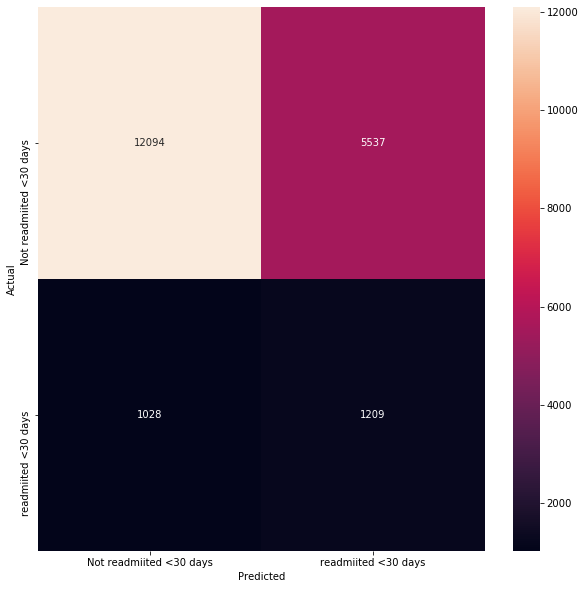

              precision    recall  f1-score   support

           0       0.92      0.69      0.79     17631
           1       0.18      0.54      0.27      2237

    accuracy                           0.67     19868
   macro avg       0.55      0.61      0.53     19868
weighted avg       0.84      0.67      0.73     19868



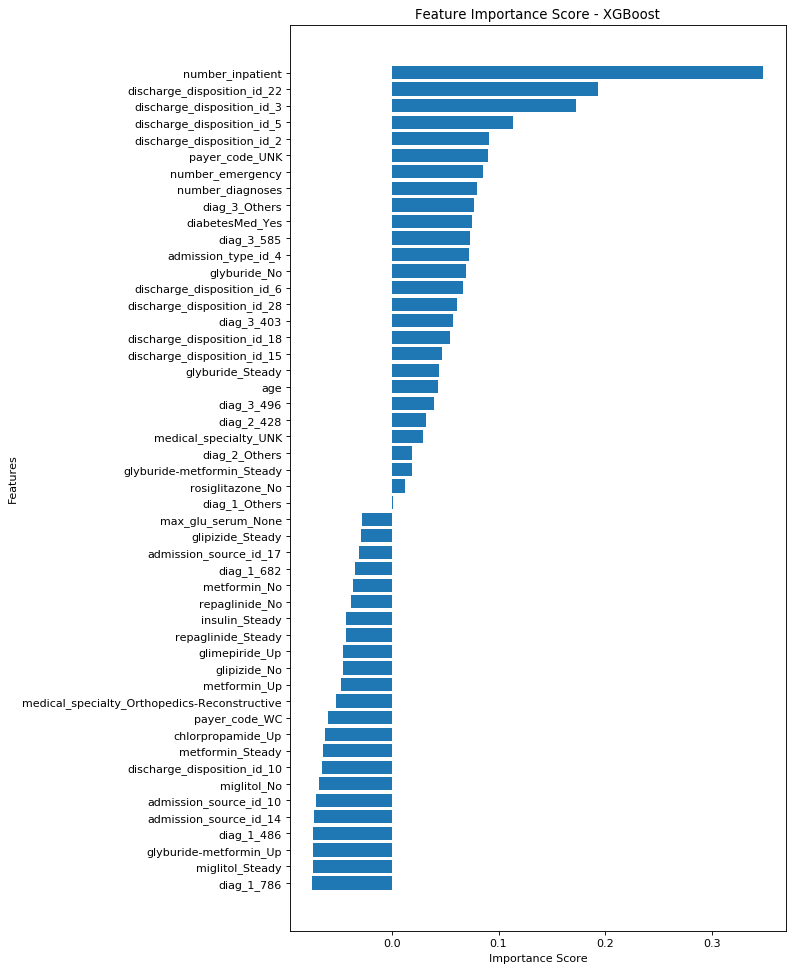

In [119]:
selection = SelectFromModel(best_lr_model, threshold=0.04, prefit=True)
undersample = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersample.fit_resample(X_train_tf, y_train)
X_train_us, y_train_us = shuffle(X_train_us, y_train_us, random_state=42)
select_X_train = selection.transform(X_train_us)

selection_model = LogisticRegression()
selection_model.fit(select_X_train, y_train_us)  

select_X_test = selection.transform(X_test_tf)
y_pred = selection_model.predict(select_X_test)
print_results(y_test, y_pred)
plot_important_features(selection_model, list(all_X_train.columns[selection.get_support()]), 50, 'Feature Importance Score - XGBoost')